In [1]:
#!pip install torch
#!pip install typing_extensions>=4.5 --upgrade
# !pip install seaborn

In [2]:
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from IPython import display
from scipy.spatial.distance import cosine
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:


def generate_random_hex_color():
    """Generates a random hexadecimal color code."""
    r = random.randint(0, 255)  # Random value for Red (0-255)
    g = random.randint(0, 255)  # Random value for Green (0-255)
    b = random.randint(0, 255)  # Random value for Blue (0-255)

    # Format the RGB values as a hex string with leading zeros if needed
    hex_color = list(f'{r:02x}{g:02x}{b:02x}')
    color_class = max(((r, 'red'), (g, 'green'), (b, 'blue')), key=lambda x: x[0])
    return hex_color + [color_class[1]]



In [4]:
random_color = generate_random_hex_color()
print(f"Random Hex Color: {random_color}")

x_train = []
col_names = [str(i) for i in range(6)]
for i in range(100000):
    x_train.append(generate_random_hex_color())
x_train = pd.DataFrame(x_train, columns=col_names + ["label"])

# Initialize a label encoder for each categorical column
encoder = {}
label_encoder = LabelEncoder()
for col in col_names:
    encoder[col] = LabelEncoder().fit(list('0123456789abcdef'))
    x_train[col] = encoder[col].transform(x_train[col])
x_train["label"] = label_encoder.fit_transform(x_train["label"])

Random Hex Color: ['b', 'd', 'c', 'c', '2', 'f', 'green']


In [5]:
len('0123456789abcdef')

16

In [6]:
x_train.sample()

,0,1,2,3,4,5,label
43364,1,10,13,14,0,14,1


In [7]:
x_train

,0,1,2,3,4,5,label
0,8,12,0,10,2,12,2
1,10,14,6,13,13,13,0
2,14,10,10,7,0,8,2
3,6,10,3,12,15,1,0
4,9,14,2,6,14,12,0
...,...,...,...,...,...,...,...
99995,10,15,4,7,12,11,0
99996,5,3,2,11,10,4,0
99997,2,10,8,11,5,8,1
99998,10,6,10,11,13,13,0


In [8]:
import torch
import torch.nn as nn

# Define the embedding sizes (you can tune the embedding_dim)
embedding_dims = {
    '0': 3,  # For example, you can experiment with this value
    '1': 3,
    '2': 3,
    '3': 3,
    '4': 3,
    '5': 3
}

# Calculate the number of unique categories for each categorical column
embedding_sizes = {col: len(encoder[col].classes_) for col in encoder}

# Create embedding layers
embedding_layers = nn.ModuleDict({
    col: nn.Embedding(num_embeddings=embedding_sizes[col], embedding_dim=embedding_dims[col])
    for col in embedding_sizes
})

# Check the embedding layers
for col, embedding_layer in embedding_layers.items():
    print(f"Embedding for {col}: {embedding_layer}")

Embedding for 0: Embedding(16, 3)
Embedding for 1: Embedding(16, 3)
Embedding for 2: Embedding(16, 3)
Embedding for 3: Embedding(16, 3)
Embedding for 4: Embedding(16, 3)
Embedding for 5: Embedding(16, 3)


In [9]:
class EmbeddingModel(nn.Module):
    def __init__(self, embedding_layers, num_classes=3):
        super(EmbeddingModel, self).__init__()
        self.embeddings = embedding_layers
        self.fc = nn.Linear(sum(embedding_dims.values()), num_classes)  # 3 logits for 3 classes

    def forward(self, x):
        embedded = [self.embeddings[col](x[:, i]) for i, col in enumerate(self.embeddings.keys())]
        x = torch.cat(embedded, dim=1)
        x = self.fc(x)  # Output logits for 3 classes
        return x

# Instantiate the model
model = EmbeddingModel(embedding_layers)
print(model)

EmbeddingModel(
  (embeddings): ModuleDict(
    (0): Embedding(16, 3)
    (1): Embedding(16, 3)
    (2): Embedding(16, 3)
    (3): Embedding(16, 3)
    (4): Embedding(16, 3)
    (5): Embedding(16, 3)
  )
  (fc): Linear(in_features=18, out_features=3, bias=True)
)


In [10]:
# Prepare data for training (convert dataframe to torch tensors)
X = torch.tensor(x_train[col_names].values, dtype=torch.long)
y = torch.tensor(x_train['label'].values, dtype=torch.long).view(-1) 

# Train the model
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2500
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)  # y should be class indices (not one-hot encoded)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/2500], Loss: 1.1092
Epoch [20/2500], Loss: 1.0915
Epoch [30/2500], Loss: 1.0756
Epoch [40/2500], Loss: 1.0612
Epoch [50/2500], Loss: 1.0479
Epoch [60/2500], Loss: 1.0355
Epoch [70/2500], Loss: 1.0236
Epoch [80/2500], Loss: 1.0121
Epoch [90/2500], Loss: 1.0008
Epoch [100/2500], Loss: 0.9897
Epoch [110/2500], Loss: 0.9786
Epoch [120/2500], Loss: 0.9676
Epoch [130/2500], Loss: 0.9564
Epoch [140/2500], Loss: 0.9452
Epoch [150/2500], Loss: 0.9338
Epoch [160/2500], Loss: 0.9223
Epoch [170/2500], Loss: 0.9106
Epoch [180/2500], Loss: 0.8988
Epoch [190/2500], Loss: 0.8867
Epoch [200/2500], Loss: 0.8746
Epoch [210/2500], Loss: 0.8622
Epoch [220/2500], Loss: 0.8497
Epoch [230/2500], Loss: 0.8371
Epoch [240/2500], Loss: 0.8244
Epoch [250/2500], Loss: 0.8115
Epoch [260/2500], Loss: 0.7985
Epoch [270/2500], Loss: 0.7855
Epoch [280/2500], Loss: 0.7724
Epoch [290/2500], Loss: 0.7592
Epoch [300/2500], Loss: 0.7460
Epoch [310/2500], Loss: 0.7328
Epoch [320/2500], Loss: 0.7197
Epoch [330/2500],

In [11]:
X_new = []
original_hex = []
for i in range(5000):
    color = generate_random_hex_color()
    original_hex.append("#" + "".join(color[:-1]))
    X_new.append(color)
X_new = pd.DataFrame(X_new, columns=col_names + ["label"])
display.display(X_new.sample(5))
for col in col_names:
    X_new[col] = encoder[col].transform(X_new[col])
#X_new["label"] = label_encoder.transform(X_new["label"])
X_new.sample(5)

,0,1,2,3,4,5,label
227,d,4,6,4,7,1,red
4620,8,3,b,c,8,7,green
3868,1,0,1,c,6,6,blue
208,c,4,c,b,b,8,green
2785,8,4,0,a,7,e,red


,0,1,2,3,4,5,label
244,15,1,7,8,14,9,red
1736,6,4,5,10,15,9,blue
745,5,11,15,12,4,2,green
4967,6,4,1,4,13,4,blue
1907,8,15,5,13,4,1,red


In [12]:
# Prediction
model.eval()

X = torch.tensor(X_new[col_names].values, dtype=torch.long)

with torch.no_grad():
    output = model(X)
    pred_probs = torch.softmax(output, dim=1)  # Apply softmax to get probabilities
    pred_class = torch.argmax(pred_probs, dim=1)  # Choose the class with the highest probability

#print(f"Predicted class: {pred_class}")
#print(f"Predicted class: {label_encoder.inverse_transform(pred_class)}")


In [13]:
# Extract embeddings

# Example: Get the embedding matrix for 'cat1'
col_1_embeddings = model.embeddings['0'].weight.data
print(col_1_embeddings.shape)  # (num_categories, embedding_dim)

# View embedding vector for a specific category (e.g., index 2)
embedding_vector = col_1_embeddings[2]
print(embedding_vector)

torch.Size([16, 3])
tensor([ 0.4682, -1.9291, -1.2492])


In [14]:
all_embeddings = {
    col: model.embeddings[col].weight.data.cpu().numpy()
    for col in model.embeddings
}
#all_embeddings

In [15]:
all_embeddings['0'].shape

(16, 3)

In [16]:
model.eval()

with torch.no_grad():
    # List of tensors, one per feature: each tensor shape is (batch_size, embedding_dim)
    embedded_vectors = [
        model.embeddings[col](X) for i, col in enumerate(model.embeddings)
    ]

    # Concatenate all embedding vectors for each row: shape (batch_size, total_embedding_dim)
    full_embeddings = torch.cat(embedded_vectors, dim=1)

In [17]:
X.shape

torch.Size([5000, 6])

In [18]:
full_embeddings.shape

torch.Size([5000, 36, 3])

In [19]:
embedding_array = full_embeddings.cpu().numpy()
embedding_array[0].shape

(36, 3)

In [20]:
full_embeddings.shape

torch.Size([5000, 36, 3])

In [21]:
embedding_array.reshape(embedding_array.shape[0], embedding_array.shape[1]*embedding_array.shape[2]).shape

(5000, 108)

In [22]:
import numpy as np

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(
    embedding_array.reshape(embedding_array.shape[0], embedding_array.shape[1]*embedding_array.shape[2])
)

X_embedded.shape

(5000, 2)

In [23]:
np.savetxt("embeddings.tsv",
           embedding_array.reshape(embedding_array.shape[0], embedding_array.shape[1]*embedding_array.shape[2]),
           delimiter="\t"
          )
np.savetxt("metadata.tsv", np.array(original_hex), delimiter="\t", fmt="%s")

/tmp/ipykernel_6138/2750167247.py:10: UserWarning: The palette list has more values (5000) than needed (4999), which may not be intended.
  sns.scatterplot(data=df, x='x', y='y', hue='color', palette=hex_colors, legend=False)


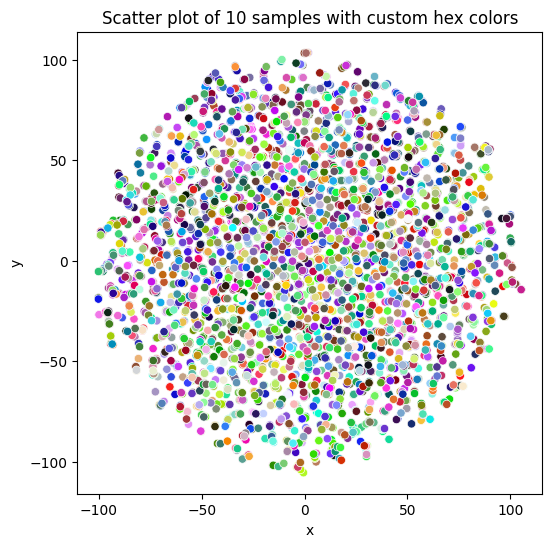

In [24]:

# Example list of 10 hex colors
hex_colors = original_hex

# Create a DataFrame for seaborn
df = pd.DataFrame(X_embedded, columns=['x', 'y'])
df['color'] = hex_colors  # Add color column

# Plot using seaborn
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x='x', y='y', hue='color', palette=hex_colors, legend=False)

plt.title("Scatter plot of 10 samples with custom hex colors")
plt.show()

In [25]:
X_new.iloc[0]['0']

np.int64(2)

What's important to note here is that the model doesn't know hexadecimal or RGB, each hexadecimal character is a categorical feature. The model has learned what each dimension represents.